<a href="https://colab.research.google.com/github/federicopessina/algorithmic-trading-python/blob/master/Forex_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

from fbprophet.plot import add_changepoints_to_plot

     |████████████████████████████████| 6.3MB 9.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=e95d5150b9a69e9f3101ff76894e16858f19c8a078098ebc0f437651228e7bd8
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Data download

In [ ]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2021-05-24')

To predict the EUR / USD exchange rate we using the following indizes, futures and currencies:
1. GBP/USD
2. USD/CHF
3. USD/JPY
4. EUR/JPY
5. USD/AUD
6. USD/CAD
7. EUR/CHF
8. Mni Dow. Jones Future (YM=F)
9. Nasdaq 100 Future (NQ=F)
10. Euro Stoxx 50 (STOXX50E)
11. FTSE 100 (FTSE)
12. Nikkei 225 (N225)
13. Dow Jones Industrial Index (DJI)
14. CBOE Volatility Index (VIX)
15. Crude Oil Future (CL=F)
16. Silver Future (SI=F)
17. Gold Future (GC=F)
18. Treasury Yield 10 Years (TNX)
19. HANG SENG INDEX (HSI)
20. Five-Year US Treasury Note Futu (ZF=F)
21. Copper Future (HG=F)
22. NASDAQ Composite (IXIC)
23. Dax 30 (GDAXI)
24. CAC 40 (FCHI)


In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X', 'EURCHF=X', 
                       'YM=F', 'NQ=F', '^STOXX50E', '^FTSE', '^N225', '^DJI', '^VIX', 'CL=F', 'SI=F', 'GC=F', '^TNX',
                       '^HSI', 'ZF=F', 'HG=F', '^IXIC', '^GDAXI', '^FCHI']

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Tail of the table with the downloaded data. Last day is the 18. June currently. Our model will predict the periode between 14.06 and 27.06

In [ ]:
forex_df.tail()

eurusd_close  gbpusd_close  ...  ^gdaxi_close  ^fchi_close
Date                                    ...                           
2021-06-16      1.212709      1.408153  ...  15710.570312  6652.649902
2021-06-17      1.199559      1.399071  ...  15727.669922  6666.259766
2021-06-18      1.191341      1.393864  ...  15448.040039  6569.160156
2021-06-21      1.187366      1.381712  ...  15603.240234  6602.540039
2021-06-22      1.189910      1.391479  ...           NaN          NaN

[5 rows x 25 columns]

In [ ]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2993 entries, 2010-01-01 to 2021-06-22
Freq: B
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   eurusd_close     2968 non-null   float64
 1   gbpusd_close     2968 non-null   float64
 2   usdchf_close     2965 non-null   float64
 3   usdjpy_close     2968 non-null   float64
 4   eurjpy_close     2970 non-null   float64
 5   usdcad_close     2967 non-null   float64
 6   audusd_close     2967 non-null   float64
 7   eurchf_close     2968 non-null   float64
 8   ym_close         2863 non-null   float64
 9   nq_close         2863 non-null   float64
 10  ^stoxx50e_close  2871 non-null   float64
 11  ^ftse_close      2889 non-null   float64
 12  ^n225_close      2807 non-null   float64
 13  ^dji_close       2886 non-null   float64
 14  ^vix_close       2886 non-null   float64
 15  cl_close         2863 non-null   float64
 16  si_close         2862 non-null   f

In [ ]:
forex_df.tail()

eurusd_close  gbpusd_close  ...  ^gdaxi_close  ^fchi_close
Date                                    ...                           
2021-06-16      1.212709      1.408153  ...  15710.570312  6652.649902
2021-06-17      1.199559      1.399071  ...  15727.669922  6666.259766
2021-06-18      1.191341      1.393864  ...  15448.040039  6569.160156
2021-06-21      1.187366      1.381712  ...  15603.240234  6602.540039
2021-06-22      1.189910      1.391479  ...           NaN          NaN

[5 rows x 25 columns]

Plotting the data for all the series we see that indices fall sharply in the beginning of 2020 and recovered then fast. Currencies have a much less common trend. For example EUR/USD went from 2010 on down with a minima between 2016/2017. Then it partially recover. GBP/USD goes down since the brexit vote, while USD/JPY is relative stable since a couple of years. Also the immage for the futures are different. Gold has reached a new peak while oil on the other side is low since a couple of years

In [ ]:
sentiment = pd.read_csv('sample_data/sentiment_data.csv', parse_dates = ['date'])

In [ ]:
sentiment.set_index('date', inplace = True)

In [ ]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1264 entries, 2018-01-02 to 2021-06-18
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  1264 non-null   float64
dtypes: float64(1)
memory usage: 19.8 KB


In [ ]:
forex_df.head()

eurusd_close  gbpusd_close  ...  ^gdaxi_close  ^fchi_close
Date                                    ...                           
2010-01-01      1.438994      1.613294  ...           NaN          NaN
2010-01-04      1.442398      1.611370  ...   6048.299805  4013.969971
2010-01-05      1.436596      1.599079  ...   6031.859863  4012.909912
2010-01-06      1.440403      1.602384  ...   6034.330078  4017.669922
2010-01-07      1.431803      1.593397  ...   6019.359863  4024.800049

[5 rows x 25 columns]

In [ ]:
sentiment.head()

sentiment
date                 
2018-01-02        2.0
2018-01-03        1.0
2018-01-04        1.0
2018-01-05        0.0
2018-01-06        2.0

In [ ]:
forex_df = pd.concat([forex_df, sentiment], axis = 1)

In [ ]:
new_df.tail()

eurusd_close  gbpusd_close  ...  ^fchi_close  sentiment
2021-06-16      1.212709      1.408153  ...  6652.649902        2.0
2021-06-17      1.199559      1.399071  ...  6666.259766        2.0
2021-06-18      1.191341      1.393864  ...  6569.160156        1.0
2021-06-21      1.187366      1.381712  ...  6602.540039        NaN
2021-06-22      1.190334      1.391575  ...          NaN        NaN

[5 rows x 26 columns]

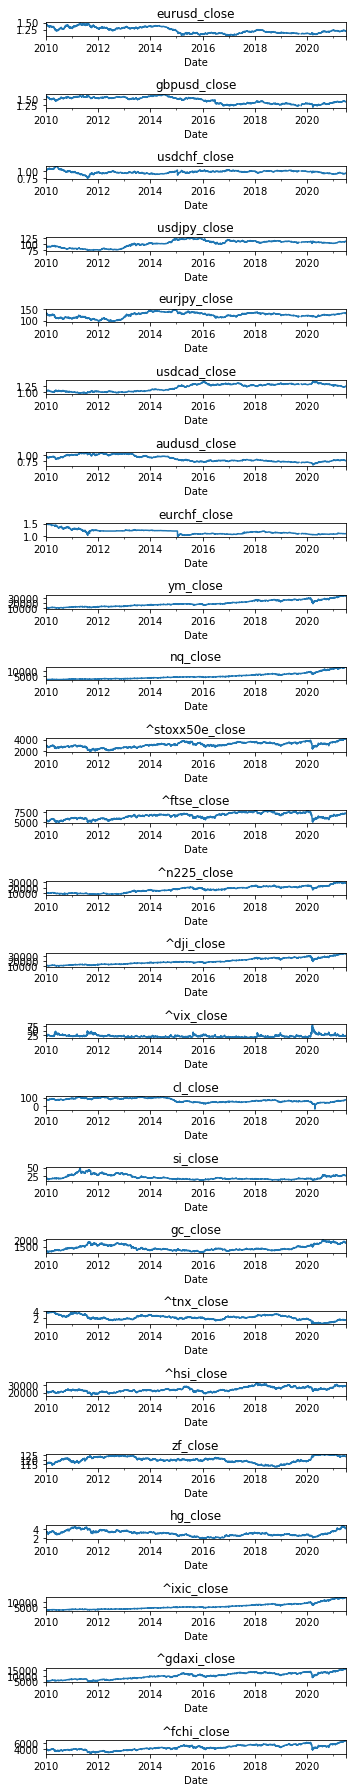

In [ ]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [ ]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [ ]:
# New Dataframe cleaned
forex_rate_df_clean.head()

eurusd_close  gbpusd_close  ...  ^gdaxi_close  ^fchi_close
Date                                    ...                           
2010-01-05     -0.004022     -0.007628  ...     -0.002718    -0.000264
2010-01-06      0.002650      0.002067  ...      0.000410     0.001186
2010-01-07     -0.005971     -0.005609  ...     -0.002481     0.001775
2010-01-08      0.006499      0.005657  ...      0.003032     0.005054
2010-01-11      0.006951      0.005543  ...      0.000479    -0.000507

[5 rows x 25 columns]

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this 
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line 

# Show plot 
fig.show()

In [ ]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000, 
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

Text(0.5, 1.0, 'Correlation Heatmap')

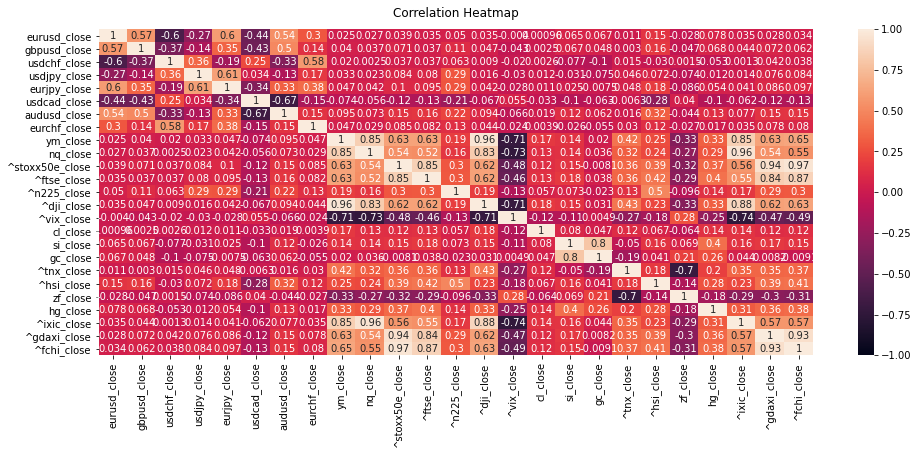

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

If we plot the correlation between the time series we see that currencies are partially correlated with each other, but jus very weak with futures and indices. The same phenomena we see for the indices. Futures are just partly correlated when it is based on an index. So is oil for example very weakly correlated with the Dow Jones Index. Interesting is that the highest correlation between EUR/USD is with the Hang Seng Index

# Error calculation

In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()

# Preprocessing

We create a new column called ds which based on the index. A second column is created with the name y which is the EUR/USD Close price. This is our target column

In [ ]:
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

eurusd_close  gbpusd_close  ...         y  sentiment
2021-06-16      1.212709      1.408153  ...  1.212709        2.0
2021-06-17      1.199559      1.399071  ...  1.199559        2.0
2021-06-18      1.191341      1.393864  ...  1.191341        1.0
2021-06-21      1.187366      1.381712  ...  1.187366        NaN
2021-06-22      1.190334      1.391575  ...  1.190334        NaN

[5 rows x 28 columns]

In [ ]:
#removing all the rows which have na values
forex_df = forex_df.dropna()

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2021-06-13']
test_window =  ['2021-06-14','2021-06-27']

In [ ]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]

In [ ]:
train.head()

eurusd_close  gbpusd_close  ...         y  sentiment
2018-01-04      1.201043      1.351132  ...  1.201043        1.0
2018-01-05      1.206884      1.355289  ...  1.206884        0.0
2018-01-09      1.197046      1.357128  ...  1.197046        1.0
2018-01-10      1.192933      1.353235  ...  1.192933        1.0
2018-01-11      1.195614      1.351278  ...  1.195614        1.0

[5 rows x 28 columns]

# Baseline model

We build now a baseline model. The idea is based that we using just the close prices of the EUR/USD exchange rate to fit a model. This model will then predict the price for the next 2 weeks

In [ ]:
m_base = Prophet(growth='linear', n_changepoints= 9)
m_base.fit(train[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#future = m_base.make_future_dataframe(test.shape[0], freq='B')
future = m_base.make_future_dataframe(10, freq='B')

The future dataframe has several rows, but just the last 10 will be relevant, since we will forecast them. The dataframe has more rows than then because we also include the history

In [ ]:
future.tail(10)

ds
730 2021-06-14
731 2021-06-15
732 2021-06-16
733 2021-06-17
734 2021-06-18
735 2021-06-21
736 2021-06-22
737 2021-06-23
738 2021-06-24
739 2021-06-25

In [ ]:
forecast_baseline = m_base.predict(future)

In [ ]:
forecast_baseline.tail(10)

ds     trend  ...  multiplicative_terms_upper      yhat
730 2021-06-14  1.228823  ...                         0.0  1.221262
731 2021-06-15  1.229044  ...                         0.0  1.223131
732 2021-06-16  1.229265  ...                         0.0  1.223388
733 2021-06-17  1.229486  ...                         0.0  1.223333
734 2021-06-18  1.229706  ...                         0.0  1.223540
735 2021-06-21  1.230369  ...                         0.0  1.224602
736 2021-06-22  1.230590  ...                         0.0  1.226236
737 2021-06-23  1.230811  ...                         0.0  1.226259
738 2021-06-24  1.231032  ...                         0.0  1.225974
739 2021-06-25  1.231252  ...                         0.0  1.225960

[10 rows x 19 columns]

These plots shows the components. In general we see that the trend is going down

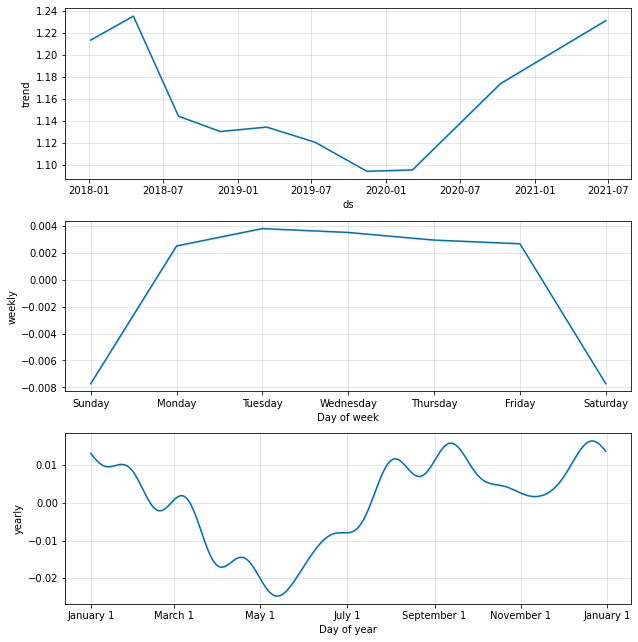

In [ ]:
fig = m_base.plot_components(forecast_baseline)

The plot for the forecast shows the points of the time series and the confidence intervall of the model

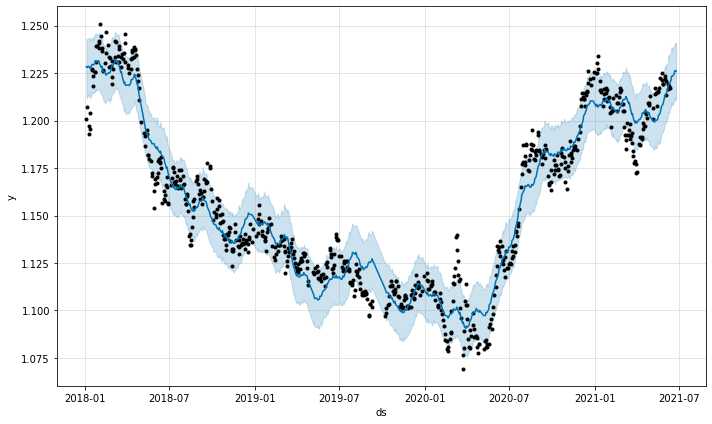

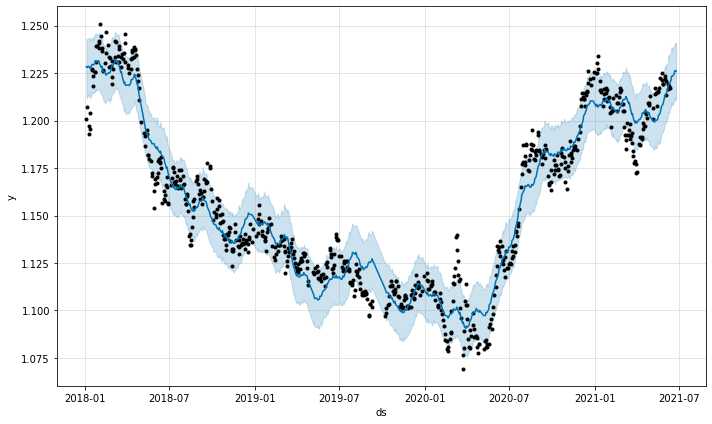

In [ ]:
m_base.plot(forecast_baseline)

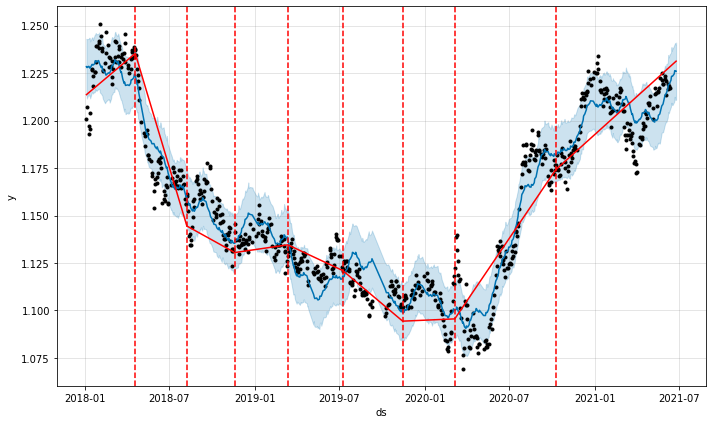

In [ ]:
fig_points = m_base.plot(forecast_baseline)
a = add_changepoints_to_plot(fig_points.gca(), m_base, forecast_baseline)

In [ ]:
forecast_baseline.set_index('ds', inplace=True)

In [ ]:
final_df_results_baseline = pd.merge(test[['eurusd_close']], forecast_baseline[['yhat']], left_index=True, right_index=True, how='inner')

Mean MAE: 0.02
MAE%: 1.61%
RMSE: 0.02
Bias: 0.02

5th percetile MAE: 0.01
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.03
95th percetile MAE: 0.03


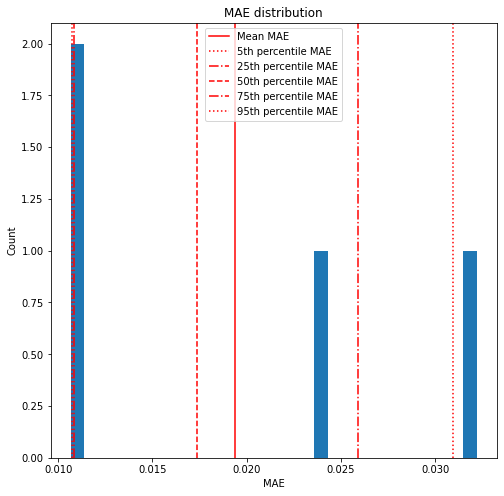

In [ ]:
calc_errors(final_df_results_baseline['eurusd_close'].values, final_df_results_baseline['yhat'].values)

In [ ]:
test

eurusd_close  gbpusd_close  ...         y  sentiment
2021-06-15      1.212224      1.410994  ...  1.212224        1.0
2021-06-16      1.212709      1.408153  ...  1.212709        2.0
2021-06-17      1.199559      1.399071  ...  1.199559        2.0
2021-06-18      1.191341      1.393864  ...  1.191341        1.0

[4 rows x 28 columns]

In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results_baseline.index, y=final_df_results_baseline['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results_baseline.index, y=final_df_results_baseline['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

# New Model

This model uses additional regressors. We using now all of the futures and indices that we downloaded before.

In [ ]:
train.head()

eurusd_close  gbpusd_close  ...         y  sentiment
2018-01-04      1.201043      1.351132  ...  1.201043        1.0
2018-01-05      1.206884      1.355289  ...  1.206884        0.0
2018-01-09      1.197046      1.357128  ...  1.197046        1.0
2018-01-10      1.192933      1.353235  ...  1.192933        1.0
2018-01-11      1.195614      1.351278  ...  1.195614        1.0

[5 rows x 28 columns]

In [ ]:
# define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints = 9,changepoint_prior_scale=0.05)
# add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['cl_close', '^dji_close', '^n225_close', '^ftse_close', '^stoxx50e_close',
                    'nq_close', 'ym_close', 'si_close', 'gc_close', '^tnx_close', '^hsi_close', 'zf_close', 'hg_close', '^ixic_close',
                   '^gdaxi_close', '^fchi_close', 'sentiment'] #, 'gbpusd_close', 'usdchf_close', 'usdjpy_close', 'eurjpy_close', 'usdcad_close',
                   #'audusd_close', 'eurchf_close']
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive')

In [ ]:
m.fit(train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#future = m.make_future_dataframe(test.shape[0], freq='B', include_history= False)
future = m.make_future_dataframe(10, freq='B')

In [ ]:
future = future.merge(forex_df[extra_regressor], left_on='ds', right_index=True, how='left').fillna(method='pad')

In [ ]:
future.tail(10)

ds   cl_close    ^dji_close  ...  ^gdaxi_close  ^fchi_close  sentiment
730 2021-06-14  70.910004  34479.601562  ...  15693.269531  6600.660156        1.0
731 2021-06-15  72.120003  34299.328125  ...  15729.519531  6639.520020        1.0
732 2021-06-16  72.150002  34033.671875  ...  15710.570312  6652.649902        2.0
733 2021-06-17  71.040001  33823.449219  ...  15727.669922  6666.259766        2.0
734 2021-06-18  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0
735 2021-06-21  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0
736 2021-06-22  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0
737 2021-06-23  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0
738 2021-06-24  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0
739 2021-06-25  71.639999  33290.078125  ...  15448.040039  6569.160156        1.0

[10 rows x 18 columns]

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.tail(10)

ds     trend  ...  multiplicative_terms_upper      yhat
730 2021-06-14  0.961206  ...                         0.0  1.218763
731 2021-06-15  0.961057  ...                         0.0  1.211423
732 2021-06-16  0.960909  ...                         0.0  1.207791
733 2021-06-17  0.960761  ...                         0.0  1.199008
734 2021-06-18  0.960613  ...                         0.0  1.202875
735 2021-06-21  0.960169  ...                         0.0  1.201307
736 2021-06-22  0.960021  ...                         0.0  1.201748
737 2021-06-23  0.959873  ...                         0.0  1.201878
738 2021-06-24  0.959725  ...                         0.0  1.200495
739 2021-06-25  0.959576  ...                         0.0  1.199876

[10 rows x 76 columns]

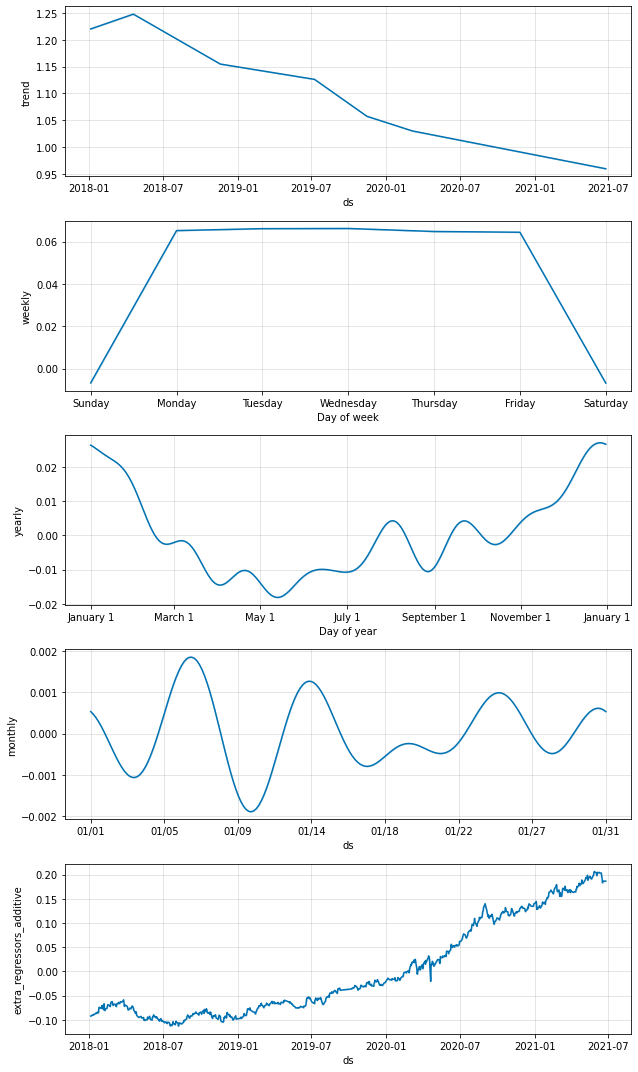

In [ ]:
fig = m.plot_components(forecast)

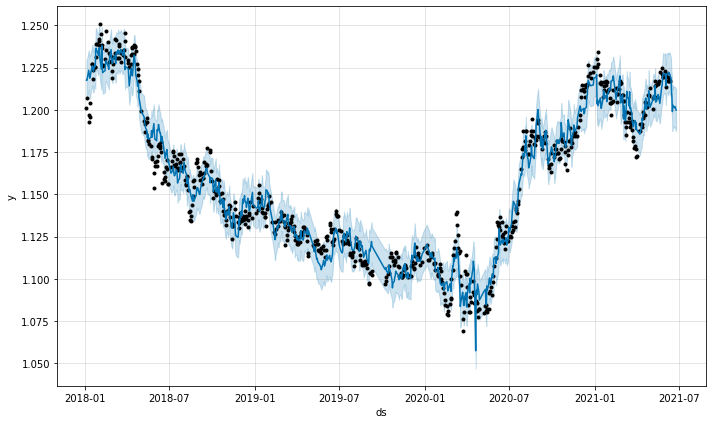

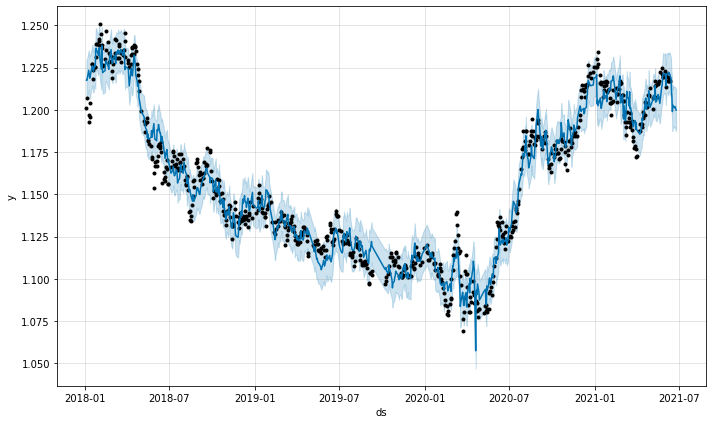

In [ ]:
m.plot(forecast)

In [ ]:
forecast.set_index('ds', inplace=True)

In [ ]:
final_df_results = pd.merge(test['eurusd_close'], forecast[['yhat']], left_index=True, right_index=True)

The error for our model is much lower than for the baseline model. But since we just have the data till the 18th june the calculation of the error is not complete

Mean MAE: 0.00
MAE%: 0.37%
RMSE: 0.01
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.00
75th percetile MAE: 0.01
95th percetile MAE: 0.01


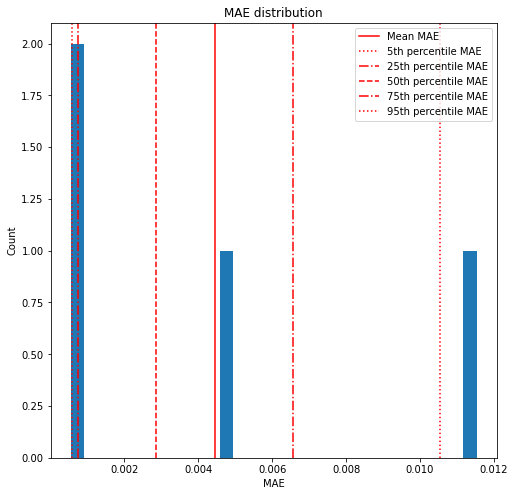

In [ ]:
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)

In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.add_trace(go.Scatter(x=final_df_results_baseline.index, y=final_df_results_baseline['yhat'],
                    mode='lines+markers',
                    name='Predicted Values (Baseline'))

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
forecast_better_model = forecast['yhat'].tail(10)
forecast_baseline_model = forecast_baseline['yhat'].tail(10)

time = forecast['yhat'].tail(10).index

Plotting the series for all the data we see that the baseline model predicts the exchange rate in a very constant way. Our model follows the up and downs of the real values much better 

In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=time, y=forecast_better_model,
                    mode='lines+markers',
                    name='Model'))

fig.add_trace(go.Scatter(x=time, y=forecast_baseline_model,
                    mode='lines+markers',
                    name='Baseline'))


fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))


fig.update_layout(template='plotly_white')
fig.show()

# Model that uses also the other exchange rates

In this model we are using also the other exchange rates as EUR/AUD,... to predict our traget rate

In [ ]:
train.head()

eurusd_close  gbpusd_close  ...         y  sentiment
2018-01-04      1.201043      1.351132  ...  1.201043        1.0
2018-01-05      1.206884      1.355289  ...  1.206884        0.0
2018-01-09      1.197046      1.357128  ...  1.197046        1.0
2018-01-10      1.192933      1.353235  ...  1.192933        1.0
2018-01-11      1.195614      1.351278  ...  1.195614        1.0

[5 rows x 28 columns]

In [ ]:
# define Prophet model with hyperparameters
m_2 = Prophet(growth='linear',n_changepoints = 9,changepoint_prior_scale=0.05)
# add custom seasonality
m_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_2.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor_2 = ['cl_close', '^dji_close', '^n225_close', '^ftse_close', '^stoxx50e_close',
                    'nq_close', 'ym_close', 'si_close', 'gc_close', '^tnx_close', '^hsi_close', 'zf_close', 'hg_close', '^ixic_close',
                   '^gdaxi_close', '^fchi_close', 'gbpusd_close', 'usdchf_close', 'usdjpy_close', 'eurjpy_close', 'usdcad_close',
                   'audusd_close', 'eurchf_close', 'sentiment']
for reg in extra_regressor_2:
  m_2.add_regressor(name=reg, mode='additive')

In [ ]:
m_2.fit(train)

future_2 = m_2.make_future_dataframe(10, freq='B')

future_2 = future_2.merge(forex_df[extra_regressor_2], left_on='ds', right_index=True, how='left').fillna(method='pad')

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_2 = m_2.predict(future_2)

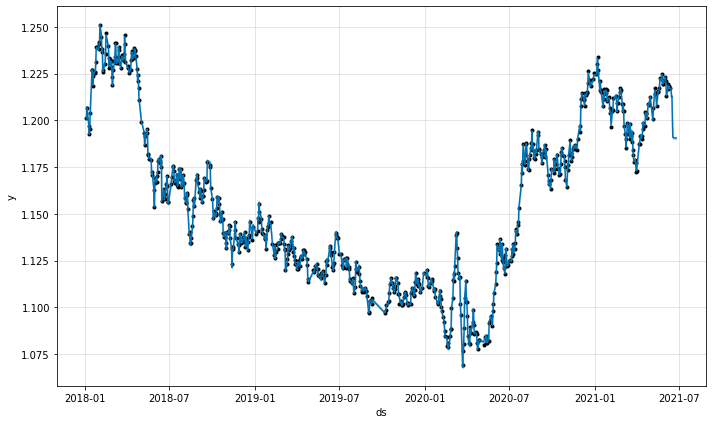

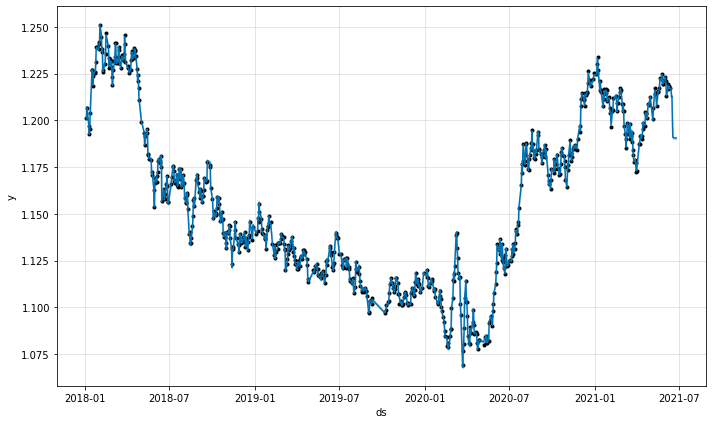

In [ ]:
m_2.plot(forecast_2)

In [ ]:
forecast_2.tail(10)

ds     trend  ...  multiplicative_terms_upper      yhat
730 2021-06-14  1.184556  ...                         0.0  1.217209
731 2021-06-15  1.184551  ...                         0.0  1.212552
732 2021-06-16  1.184547  ...                         0.0  1.213030
733 2021-06-17  1.184542  ...                         0.0  1.199879
734 2021-06-18  1.184538  ...                         0.0  1.190816
735 2021-06-21  1.184525  ...                         0.0  1.190681
736 2021-06-22  1.184520  ...                         0.0  1.190654
737 2021-06-23  1.184516  ...                         0.0  1.190622
738 2021-06-24  1.184511  ...                         0.0  1.190611
739 2021-06-25  1.184507  ...                         0.0  1.190569

[10 rows x 97 columns]

If we use all the other currencies the error goes more down as before

Mean MAE: 0.00
MAE%: 0.03%
RMSE: 0.00
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.00
75th percetile MAE: 0.00
95th percetile MAE: 0.00


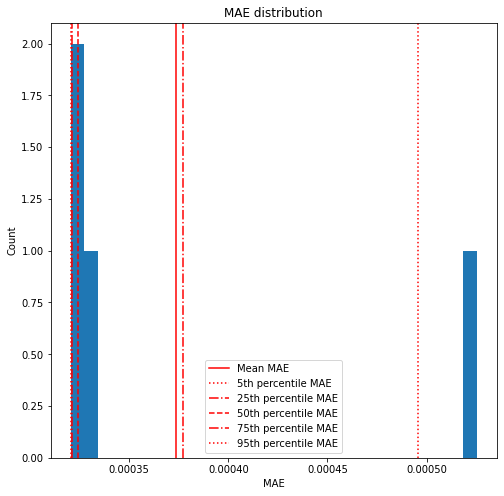

In [ ]:
forecast_2.set_index('ds', inplace=True)

final_df_results_all = pd.merge(test['eurusd_close'], forecast_2[['yhat']], left_index=True, right_index=True)

calc_errors(final_df_results_all['eurusd_close'].values, final_df_results_all['yhat'].values)

In [ ]:
forecast_all_model = forecast_2['yhat'].tail(10)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=time, y=forecast_better_model,
                    mode='lines+markers',
                    name='Model'))

fig.add_trace(go.Scatter(x=time, y=forecast_baseline_model,
                    mode='lines+markers',
                    name='Baseline'))


fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=time, y=forecast_all_model,
                    mode='lines+markers',
                    name='Model with all currencies '))


fig.update_layout(template='plotly_white')
fig.show()

# Conclusion

Additional regressors improved the performance of the model. We can it improve even more by using the other currencies as well. That the result improves so much is not a big surprise. When we check again the correlation heatmap we see that the currencies exchange rates are very correlated with each other

# Cross Validation

In [ ]:
from fbprophet.diagnostics import cross_validation

In [ ]:
df_cv = cross_validation(m_2, initial='730 days', period='20 days', horizon = '10 days', parallel="processes")

INFO:fbprophet:Making 342 forecasts with cutoffs between 2012-01-10 00:00:00 and 2021-06-01 00:00:00


In [ ]:
df_cv.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2012-01-11  1.277089    1.276036    1.278291  1.275185 2012-01-10
1 2012-01-12  1.273830    1.272753    1.274992  1.272394 2012-01-10
2 2012-01-13  1.282333    1.281194    1.283460  1.282051 2012-01-10
3 2012-01-17  1.268861    1.267708    1.269967  1.266705 2012-01-10
4 2012-01-18  1.275857    1.274671    1.277050  1.274600 2012-01-10

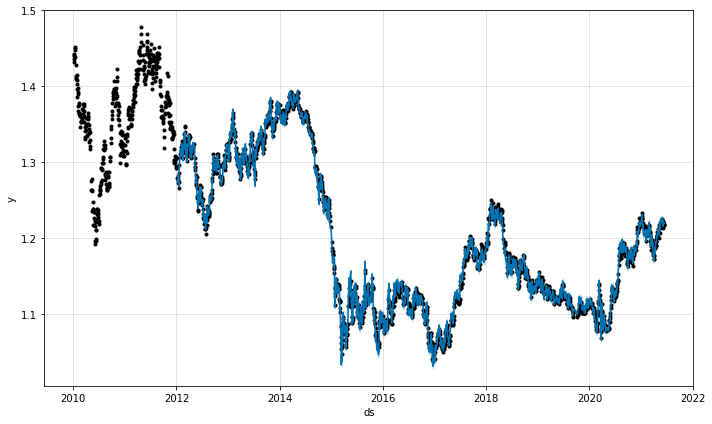

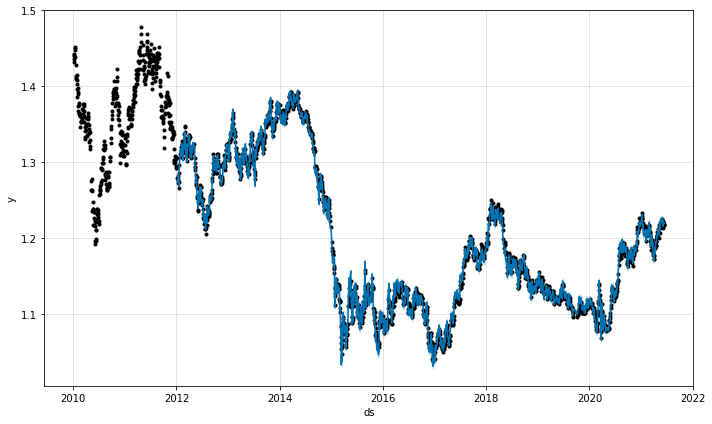

In [ ]:
m_2.plot(df_cv)

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(10)

horizon       mse      rmse       mae      mape     mdape  coverage
0  1 days  0.000011  0.003245  0.002460  0.002106  0.001576  0.612745
1  2 days  0.000011  0.003315  0.002557  0.002186  0.001666  0.600502
2  3 days  0.000012  0.003471  0.002589  0.002214  0.001667  0.635922
3  4 days  0.000013  0.003673  0.002730  0.002335  0.001823  0.607656
4  5 days  0.000013  0.003636  0.002835  0.002424  0.001961  0.546798
5  6 days  0.000012  0.003515  0.002697  0.002300  0.001873  0.592417
6  7 days  0.000015  0.003902  0.002909  0.002491  0.001879  0.584923
7  8 days  0.000017  0.004075  0.003167  0.002695  0.002291  0.509524
8  9 days  0.000015  0.003875  0.003051  0.002593  0.002157  0.542060
9 10 days  0.000014  0.003715  0.002990  0.002532  0.002061  0.521951

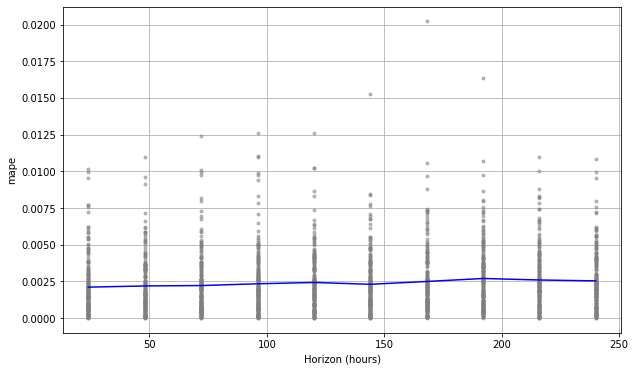

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


Mean MAE: 0.00
MAE%: 0.23%
RMSE: 0.00
Bias: -0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.00
75th percetile MAE: 0.00
95th percetile MAE: 0.01


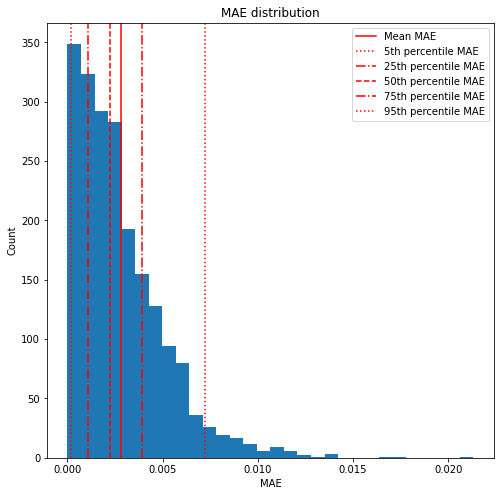

In [ ]:
qqq = df_cv
#qqq.set_index('ds', inplace=True)

r = pd.merge(train['eurusd_close'], qqq[['yhat']], left_index=True, right_index=True)

calc_errors(r['eurusd_close'].values, r['yhat'].values)

In [ ]:
qqq

yhat  yhat_lower  yhat_upper         y     cutoff
ds                                                               
2012-01-11  1.277089    1.276036    1.278291  1.275185 2012-01-10
2012-01-12  1.273830    1.272753    1.274992  1.272394 2012-01-10
2012-01-13  1.282333    1.281194    1.283460  1.282051 2012-01-10
2012-01-17  1.268861    1.267708    1.269967  1.266705 2012-01-10
2012-01-18  1.275857    1.274671    1.277050  1.274600 2012-01-10
...              ...         ...         ...       ...        ...
2021-06-07  1.219715    1.215853    1.223274  1.216841 2021-06-01
2021-06-08  1.221645    1.217524    1.225617  1.219363 2021-06-01
2021-06-09  1.220655    1.216701    1.224711  1.217285 2021-06-01
2021-06-10  1.220466    1.216370    1.224348  1.218200 2021-06-01
2021-06-11  1.219730    1.215729    1.223813  1.217256 2021-06-01

[2037 rows x 5 columns]

In [ ]:
f_cast_cv = qqq['yhat']
true_cv = qqq['y']

time = qqq.index

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=time, y=f_cast_cv,
                    mode='lines+markers',
                    name='Model'))

fig.add_trace(go.Scatter(x=time, y=true_cv,
                    mode='lines+markers',
                    name='true', opacity = 0.2))


fig.update_layout(template='plotly_white')
fig.show()